<a id="subcluster_mono_and_dc"></a>
## Sub-cluster Monocytes and DCs

Autosaving every 60 seconds


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


scanpy==1.4.4.post1 anndata==0.7.1 umap==0.3.10 numpy==1.18.1 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1


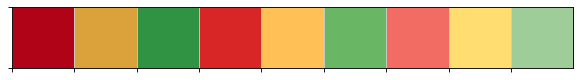

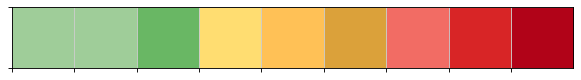

In [1]:
%matplotlib inline
%autosave 60
#%load_ext autoreload
#%autoreload 2


import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os

## Functions for reading files straight from google cloud storage
import sys
sys.path.append('../../../../Code')
from utils import save_adata, read_adata, pca_cytof

import palettable
from IPython.display import display

from joblib import parallel_backend

from scipy.stats import ranksums

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80, vector_friendly=False, ipython_format='png')

colors = np.array([x for x in palettable.tableau.TrafficLight_9.mpl_colors])
sns.palplot(colors)
sns.palplot(colors[[8,8,5, 7, 4, 1, 6,3,0], :])
dpimap = dict(zip(['0', '1', '2', '3', '4', '5', '6', '7', '8'], colors[[8,8,5, 7, 4, 1, 6,3,0], :]))
dpimap['0'] = palettable.tableau.TableauMedium_10.mpl_colors[-1]



In [2]:
adir = '../../../../../data/InVivo/Cytof/'
project_name = 'Full_IRF_SerialSac_Cytof_Fixid.1M'
results_dir = '../../../../../results'

gcs = False

In [3]:
sample_file = os.path.join(adir, project_name + '.DoubletFilt.COMBAT.SubtractCNMF.UMAP.Leiden.h5ad')

In [4]:
adata = read_adata(sample_file, ext='.h5ad', gcs=gcs)

Only considering the two last: ['.Leiden', '.h5ad'].
Only considering the two last: ['.Leiden', '.h5ad'].


In [5]:
adata

AnnData object with n_obs × n_vars = 943558 × 42 
    obs: 'BCKG190Di_CKG', 'Ba138Di_Ba138Di', 'Center', 'Cs133Di_Environ', 'DNA1', 'DNA1_Norm', 'DNA2', 'DNA2_Norm', 'DNA_Norm_Sum', 'DNA_Sum_Norm', 'DPI', 'DPIc', 'Event_length', 'I127Di_127I', 'Multiplex_Barcode', 'Multiplex_Group', 'Offset', 'Pb208Di_Environ', 'Pd102Di_BC1', 'Pd104Di_BC2', 'Pd105Di_BC3', 'Pd106Di_BC4', 'Pd108Di_BC5', 'Pd110Di_BC6', 'Period', 'Residual', 'Sn120Di_Environ', 'Time', 'Width', 'Xe131Di_Environ', 'animal', 'batch', 'clinical_score', 'context', 'intensity_sum', 'is_doublet', 'leiden', 'leiden_lab', 'leiden_lab_group', 'n_counts', 'n_genes', 'num', 'samp', 'sample', 'sum_intensity', 'leiden14', 'leiden13', 'leiden10', 'leiden12', 'Subclustering', 'SubclusteringGroup', 'Doublet'
    var: 'gene_symbol', 'metal', 'full_id'
    uns: 'DPIc_colors', 'leiden', 'leiden10_colors', 'leiden12_colors', 'leiden13_colors', 'leiden14_colors', 'leiden_colors', 'leiden_lab_colors', 'leiden_lab_group_colors', 'neighbors', 'pca

In [6]:
adata.obs['leiden_lab_group'].unique()

[Mono/DC, Neut, HLA-DR_high, Th, B, Plasmablast, NK, Tc, Doublet, RBC]
Categories (10, object): [Mono/DC, Neut, HLA-DR_high, Th, ..., NK, Tc, Doublet, RBC]

In [7]:
adata_myeloid = adata[adata.obs['leiden_lab_group'].isin(['Mono/DC', 'Neut', 'HLA-DR_high']),:]

In [8]:
adata_myeloid = adata_myeloid.copy()

In [9]:
adata_myeloid.obs['leiden_lab_group'].unique()

[Mono/DC, Neut, HLA-DR_high]
Categories (3, object): [Mono/DC, Neut, HLA-DR_high]

In [10]:
adata_myeloid.obsm = None

In [11]:
adata_myeloid.obs.columns

Index(['BCKG190Di_CKG', 'Ba138Di_Ba138Di', 'Center', 'Cs133Di_Environ', 'DNA1',
       'DNA1_Norm', 'DNA2', 'DNA2_Norm', 'DNA_Norm_Sum', 'DNA_Sum_Norm', 'DPI',
       'DPIc', 'Event_length', 'I127Di_127I', 'Multiplex_Barcode',
       'Multiplex_Group', 'Offset', 'Pb208Di_Environ', 'Pd102Di_BC1',
       'Pd104Di_BC2', 'Pd105Di_BC3', 'Pd106Di_BC4', 'Pd108Di_BC5',
       'Pd110Di_BC6', 'Period', 'Residual', 'Sn120Di_Environ', 'Time', 'Width',
       'Xe131Di_Environ', 'animal', 'batch', 'clinical_score', 'context',
       'intensity_sum', 'is_doublet', 'leiden', 'leiden_lab',
       'leiden_lab_group', 'n_counts', 'n_genes', 'num', 'samp', 'sample',
       'sum_intensity', 'leiden14', 'leiden13', 'leiden10', 'leiden12',
       'Subclustering', 'SubclusteringGroup', 'Doublet'],
      dtype='object')

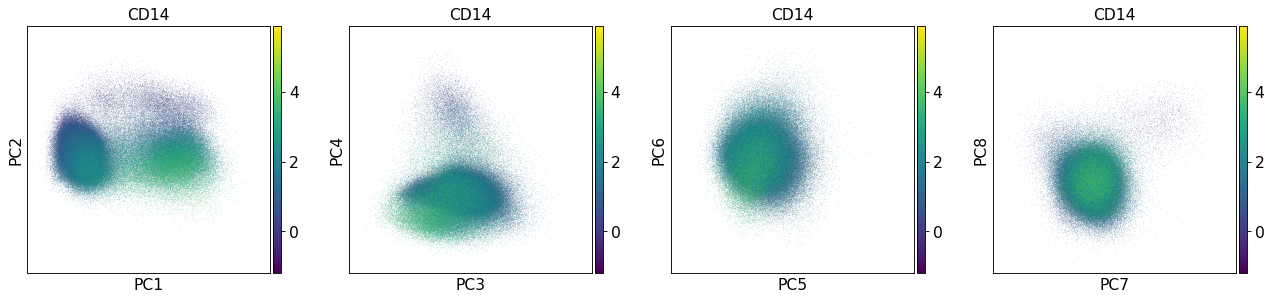

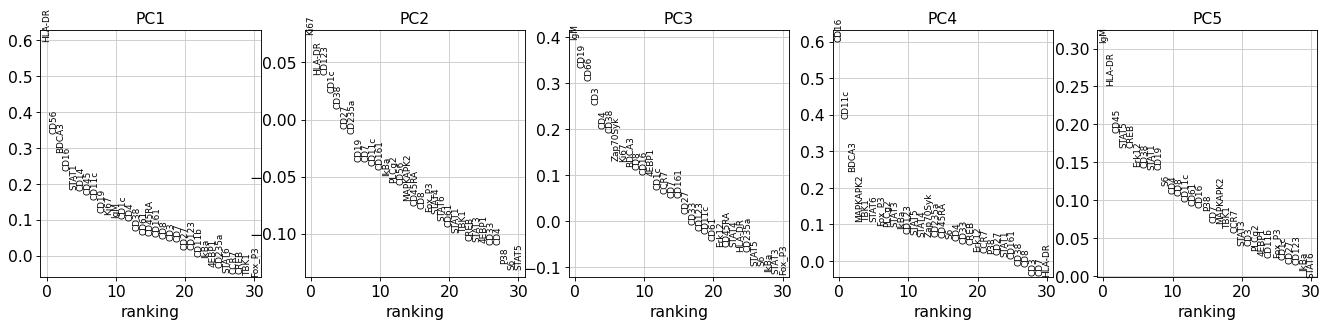

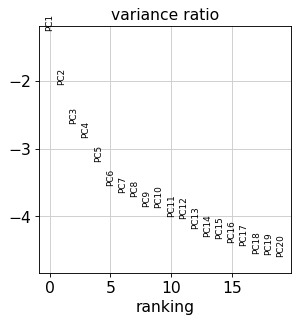

computing neighbors


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../../../../opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../..

    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:04:16)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:11:56)
running Leiden clustering
    finished: found 15 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (1:11:48)


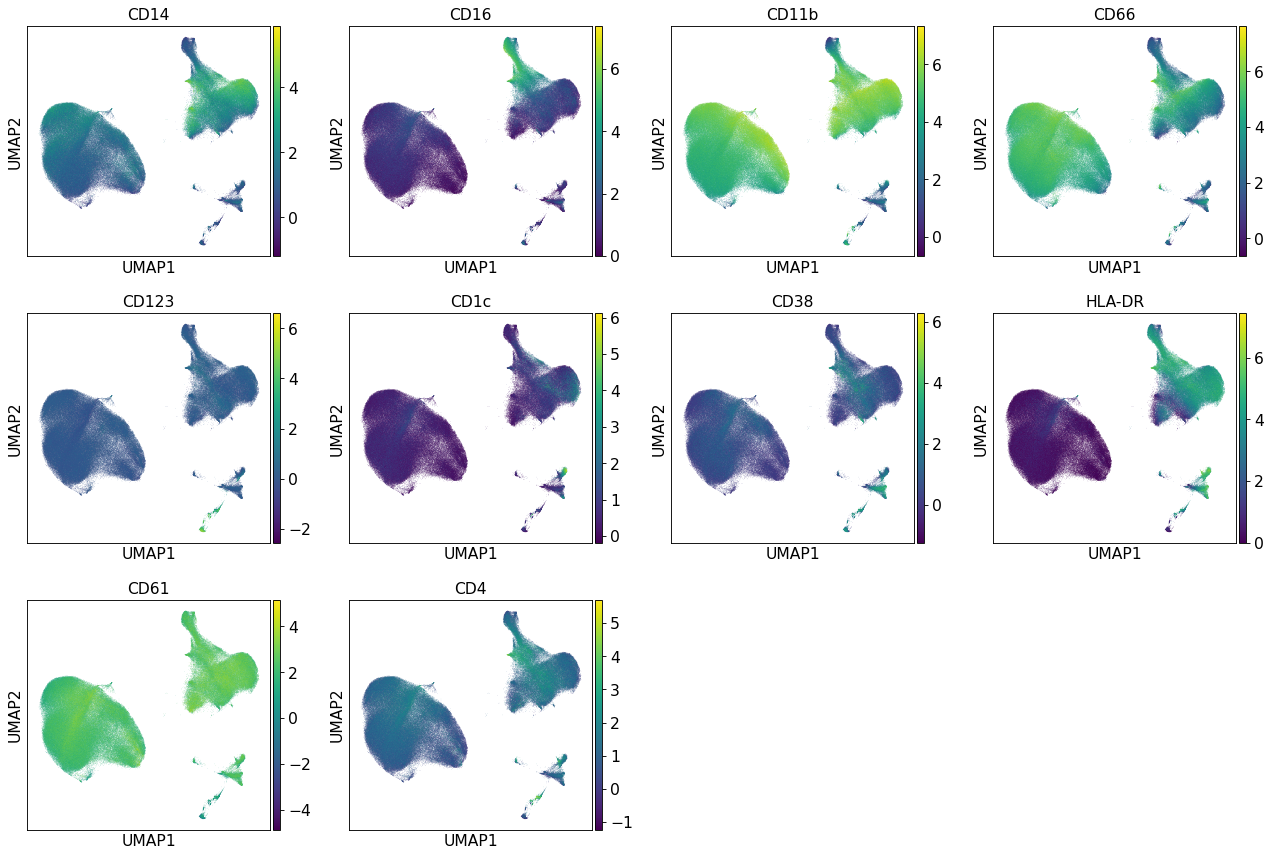

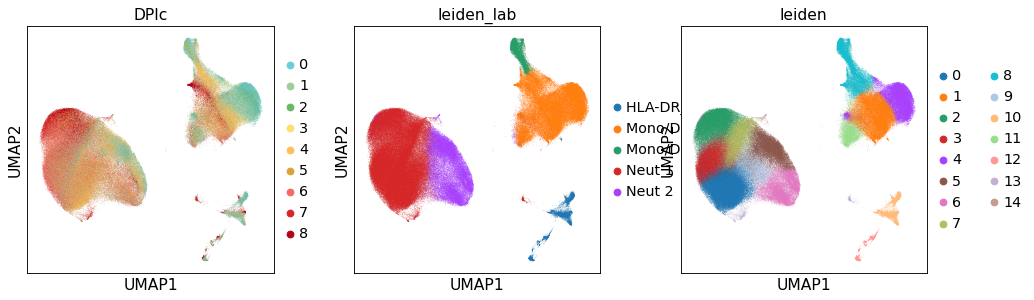

ranking genes


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:388: RuntimeWarning: invalid value encountered in log2
  rankings_gene_logfoldchanges.append(np.log2(foldchanges[global_indices]))


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:03)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,CD235a,CD45,CCR7,CD66,CD56,CCR7,CREB,IgM,CD16,Erk12,HLA-DR,CD45,CD123,Fox_P3,IgM
1,CD66,BDCA3,Fox_P3,Zap70Syk,HLA-DR,CD11b,S6,CD3,CD11c,S6,Ki67,STAT1,CD38,STAT6,STAT5
2,Zap70Syk,STAT1,STAT6,Ki67,CD14,Erk12,PLCg2,CD66,HLA-DR,CD66,CD38,CREB,HLA-DR,IkBa,CD123
3,CD33,HLA-DR,CD66,BDCA3,CD45,S6,MAPKAPK2,CD19,BDCA3,STAT3,CD19,CD14,CD16,TBK1,CD19
4,4EBP1,Ki67,TBK1,STAT3,STAT1,CREB,IkBa,Zap70Syk,STAT1,4EBP1,CD1c,CD61,CD19,CD45RA,S6
5,STAT4,CD56,IkBa,Erk12,CD11b,CD66,P38,CD4,CD56,Zap70Syk,CD56,IkBa,CD1c,PLCg2,CD66
6,Erk12,IgM,BDCA3,CD235a,CD1c,PLCg2,STAT6,CD8,CD45,CCR7,CD27,P38,CD4,STAT4,Erk12
7,CD19,CD14,STAT4,S6,BDCA3,CD33,STAT3,CD7,CD4,STAT5,STAT1,HLA-DR,CD11c,IgM,CD33


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,52.277916,212.220367,188.856461,149.295090,280.247559,189.021240,136.476410,144.022644,253.285797,133.235657,130.157349,104.967766,103.190056,19.433521,41.249664
1,34.543427,206.787857,179.220352,122.451828,224.721603,183.086746,120.320740,142.272873,232.351547,119.843285,124.108315,92.450760,85.088539,16.438791,36.671001
2,25.462982,196.763672,177.005966,87.802780,216.194412,161.399216,114.788765,138.472382,198.252258,107.578575,117.783356,86.629463,16.339706,15.020634,9.100428
3,12.504442,196.678345,166.767975,64.456131,181.014114,139.103958,114.259796,136.530258,198.121475,102.799156,70.036133,75.861443,11.770396,11.415527,8.807600
4,10.016255,191.952728,166.419952,56.517239,165.850494,129.458130,101.202011,109.393974,159.701447,101.074799,61.802170,71.909645,9.786042,9.699681,8.203864
5,1.556676,170.574432,150.204803,39.206970,155.311050,128.572800,97.946716,99.561836,128.390717,95.852890,58.993156,56.661247,7.265227,7.598416,7.298575
6,-14.406954,147.471527,136.681854,37.903572,107.468987,128.158142,96.813339,94.840874,111.906662,91.652008,23.252731,53.623219,6.530614,5.593763,5.998324
7,-14.626328,143.235397,134.652939,27.412853,105.380943,126.900070,89.449059,75.350952,111.648712,85.093086,18.304934,53.109715,3.609014,3.665868,4.838883


In [14]:
_adata = adata_myeloid.copy()
npcs=13
n_neighbors=int(_adata.shape[0]*.0001)
min_dist=0.1
spread=2.0
resolution=1.
umap_genestoplot=['CD14', 'CD16', 'CD11b', 'CD66', 'CD123', 'CD1c', 'CD38', 'HLA-DR', 'CD61', 'CD4']
pc_genestoplot=['CD14']
other_plot=['DPIc', 'leiden_lab', 'leiden']
random_state=14

pca_cytof(_adata)
sc.pl.pca(_adata, components=['1,2', '3,4', '5,6', '7,8'], color=pc_genestoplot,
          ncols=4)
sc.pl.pca_loadings(_adata, components=[1,2,3,4,5])
sc.pl.pca_variance_ratio(_adata, log=True)

sc.pp.neighbors(_adata, n_neighbors=n_neighbors, n_pcs=npcs, random_state=random_state,
                    use_rep='X_pca')
sc.tl.umap(_adata, min_dist=min_dist, spread=spread, random_state=random_state)

np.random.seed(random_state)
sc.tl.leiden(_adata, resolution=resolution, random_state=random_state)
    
fig = sc.pl.umap(_adata, color=umap_genestoplot)
fig = sc.pl.umap(_adata, color=other_plot)

sc.tl.rank_genes_groups(_adata, 'leiden', method='wilcoxon')
display(pd.DataFrame(_adata.uns['rank_genes_groups']['names']).head(8))
display(pd.DataFrame(_adata.uns['rank_genes_groups']['scores']).head(8))
adata_myeloid_1 = _adata.copy()

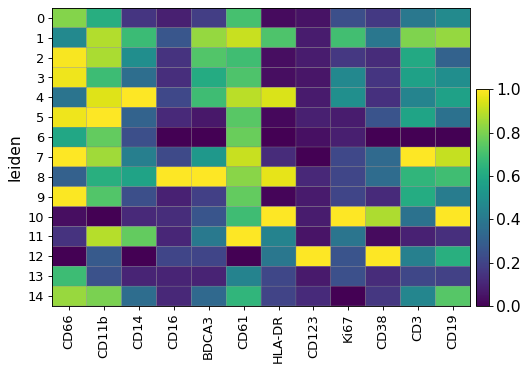

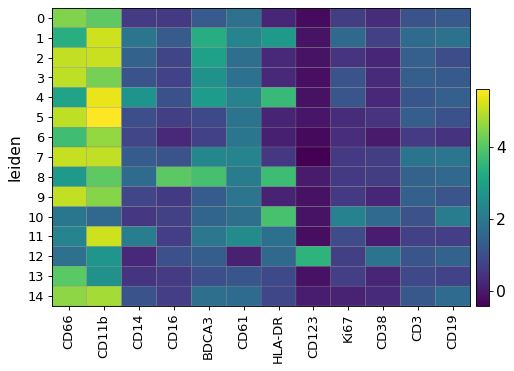

In [21]:
marker_genes = ['CD66', 'CD11b', 'CD14', 'CD16', 'BDCA3', 'CD61', 'HLA-DR', 'CD123', 'Ki67', 'CD38', 'CD3', 'CD19']
gs = sc.pl.matrixplot(adata_myeloid_1,marker_genes, groupby='leiden', figsize=(7,5), standard_scale='var')
gs = sc.pl.matrixplot(adata_myeloid_1,marker_genes, groupby='leiden', figsize=(7,5), standard_scale=None)

In [17]:
labmap = {'0':'Neut 1',
         '1':'Mono 1',
         '2':'Neut 2',
         '3':'Neut 3',
         '4':'Mono 2',
         '5':'Neut 4',
         '6':'Neut 5',
         '7':'Neut 6',
         '8':'Mono 3',
         '9':'Neut 7',
         '10':'Unassigned_APC (HLA-DR+ Ki67+)',
         '11':'Mono 4',
         '12':'CD123+',
         '13':'Neut 8',
         '14':'Neut 9'}

In [18]:
adata_myeloid_1.obs['leiden_lab'] = adata_myeloid_1.obs['leiden'].replace(labmap)
adata_myeloid_1.obs['leiden_lab_group'] = adata_myeloid_1.obs['leiden_lab'].apply(lambda x: x.split(' ')[0])

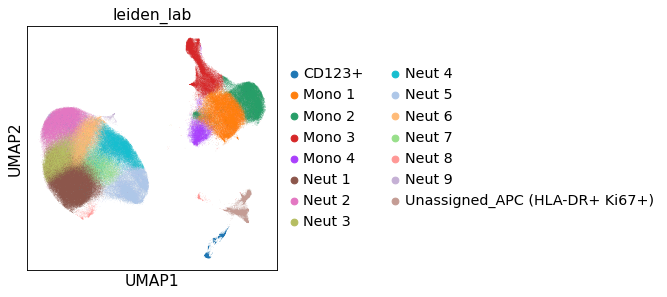

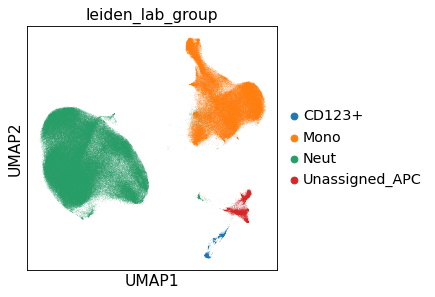

In [22]:
#sc.pl.umap(adata_myeloid_1, color='leiden')
sc.pl.umap(adata_myeloid_1, color='leiden_lab')
sc.pl.umap(adata_myeloid_1, color='leiden_lab_group')

In [23]:
myeloid_file = os.path.join(adir, project_name + '.DoubletFilt.COMBAT.SubtractCNMF.UMAP.Leiden.MyeloidIter1.h5ad')
print(myeloid_file)

../../../../../data/InVivo/Cytof/Full_IRF_SerialSac_Cytof_Fixid.1M.DoubletFilt.COMBAT.SubtractCNMF.UMAP.Leiden.MyeloidIter1.h5ad


In [24]:
save_adata(adata_myeloid_1, myeloid_file, gcs=gcs)

Only considering the two last: ['.MyeloidIter1', '.h5ad'].
Only considering the two last: ['.MyeloidIter1', '.h5ad'].


In [25]:
adata_myeloid_1.obs.loc[adata_myeloid_1.obs['leiden_lab'].isin(['Unassigned_APC (HLA-DR+ Ki67+)', 'CD123+']), 'leiden_lab'].value_counts()

Unassigned_APC (HLA-DR+ Ki67+)    10296
CD123+                             3600
Neut 9                                0
Neut 8                                0
Neut 7                                0
Neut 6                                0
Neut 5                                0
Neut 4                                0
Neut 3                                0
Neut 2                                0
Neut 1                                0
Mono 4                                0
Mono 3                                0
Mono 2                                0
Mono 1                                0
Name: leiden_lab, dtype: int64

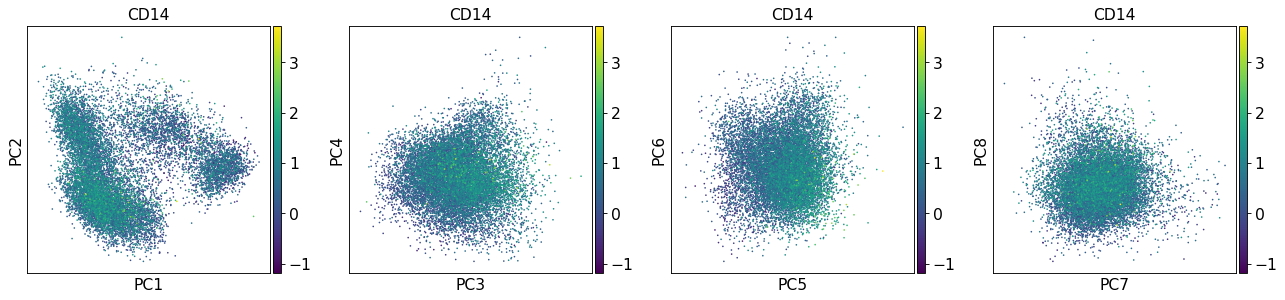

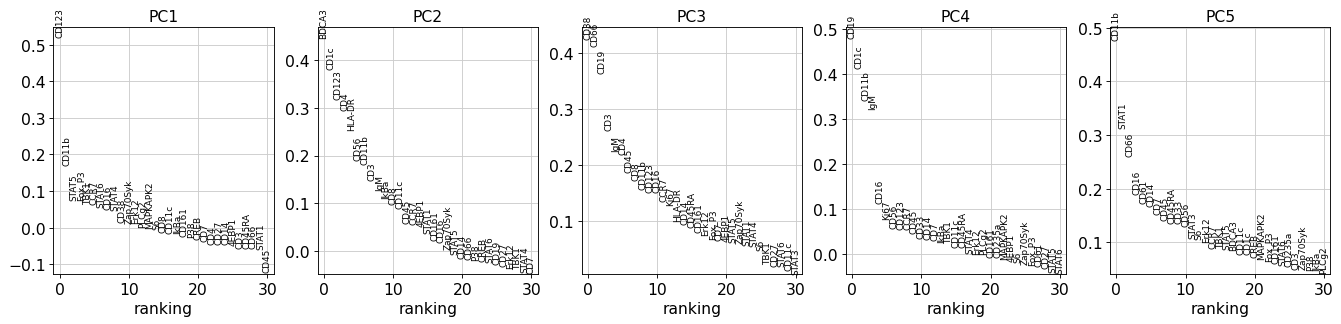

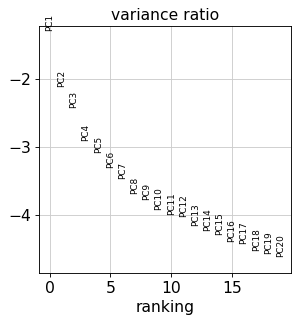

computing neighbors


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../../../../opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:07)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:21)
running Leiden clustering
    finished: found 13 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:08)


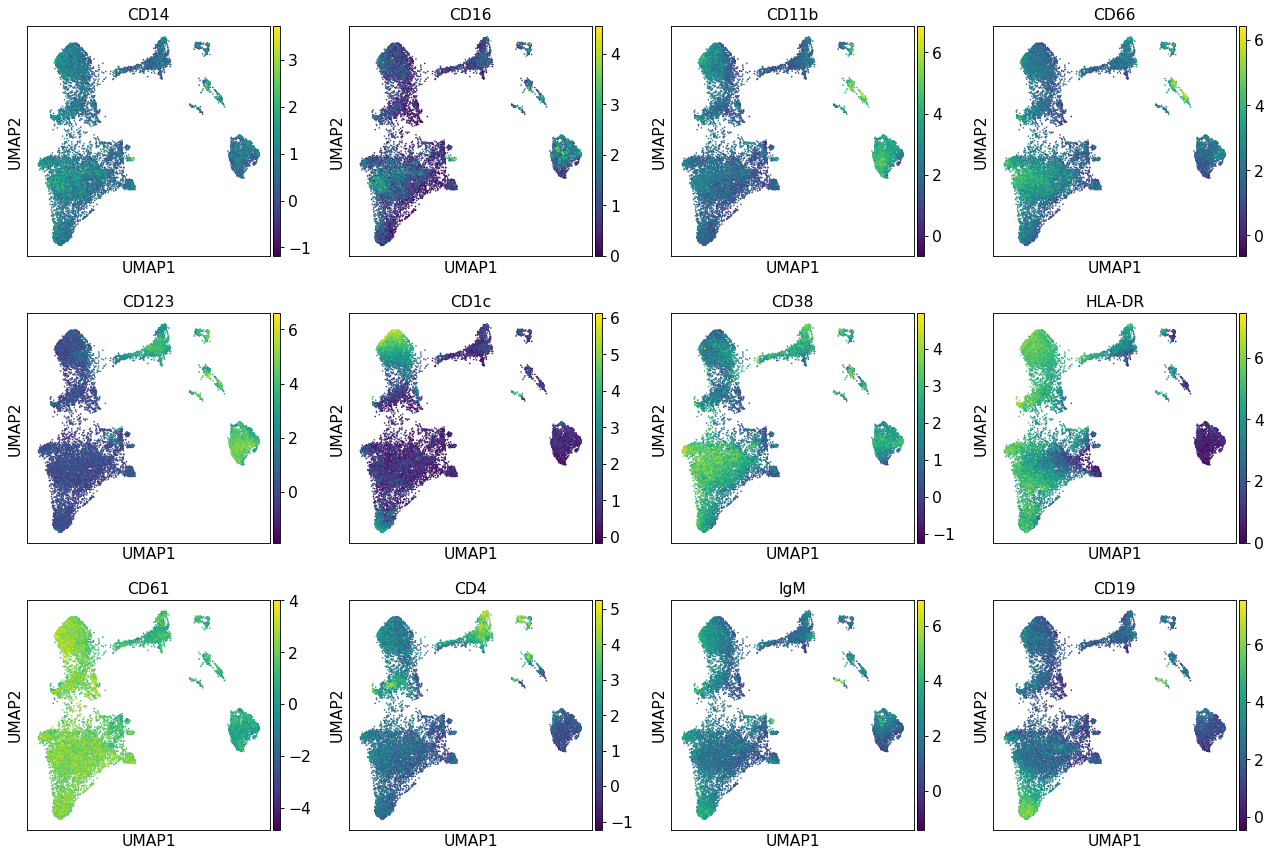

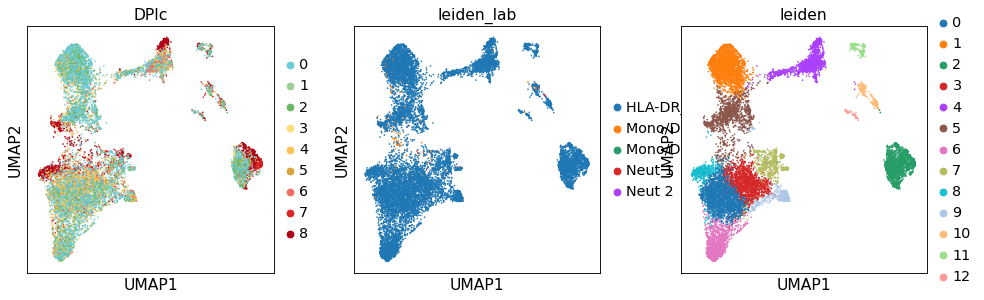

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:388: RuntimeWarning: invalid value encountered in log2
  rankings_gene_logfoldchanges.append(np.log2(foldchanges[global_indices]))


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,Ki67,CD1c,CD123,STAT3,CD4,BDCA3,CD19,PLCg2,CD38,STAT3,CD11b,CD3,CD19
1,CD66,CD56,CD11b,CD235a,CD123,CD4,Ki67,STAT6,STAT1,PLCg2,CD66,CD4,IgM
2,CD38,BDCA3,CCR7,Ki67,BDCA3,HLA-DR,IgM,CD235a,HLA-DR,CD235a,CD123,CD45,CD123
3,STAT3,HLA-DR,TBK1,CD38,CD8,CREB,CD45,Fox_P3,CD66,CD45,CCR7,CD123,CD1c
4,CD61,IkBa,Fox_P3,CD61,CD38,CD11c,CD235a,MAPKAPK2,IgM,MAPKAPK2,Zap70Syk,CD8,CD45
5,CD235a,CD61,STAT5,CD33,4EBP1,STAT1,STAT3,CD45RA,CD33,CREB,Erk12,CD7,4EBP1
6,CD45RA,CD11c,CD16,PLCg2,CD3,P38,CD33,STAT4,CD45RA,S6,CD3,CD66,CD11b
7,CD14,CD33,STAT4,CD45RA,IkBa,CD61,PLCg2,TBK1,CD45,STAT6,CD16,CCR7,CD8


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,51.847446,72.358513,63.742718,21.534140,52.318642,31.891899,55.191673,9.657712,27.987457,20.759699,28.314436,27.134302,16.136202
1,43.882126,65.012642,56.051781,21.183258,41.489830,26.987431,39.013866,8.433276,25.757271,19.401577,27.088076,21.595619,15.977107
2,39.276798,59.759281,44.164009,17.897823,27.157276,24.970671,37.632484,7.099711,24.922604,17.331253,21.351355,21.490425,12.298140
3,35.596024,54.477787,36.955276,17.819870,12.764761,22.590818,29.654713,6.713297,23.283573,16.048504,19.664528,19.332153,12.285654
4,29.621521,43.580196,34.518524,13.342822,11.381240,19.842117,28.499048,5.064626,20.549095,16.016842,16.381525,16.891113,9.178728
5,28.847464,26.451349,30.202522,13.225892,10.700281,19.452980,28.423517,2.464152,20.407427,13.784877,15.388970,15.549112,8.531177
6,23.241211,22.928278,29.039957,11.997826,9.675406,18.860622,20.013754,2.379681,19.540907,12.933270,13.494202,13.815064,7.242492
7,22.468098,22.864872,25.241884,11.146008,7.553464,17.169054,19.256092,0.946249,19.126904,12.855560,13.217894,13.260099,6.594247


In [26]:
_adata = adata_myeloid[adata_myeloid_1.obs['leiden_lab'].isin(['Unassigned_APC (HLA-DR+ Ki67+)', 'CD123+']), :].copy()
npcs=10
n_neighbors=30
min_dist=0.1
spread=2.0
resolution=1.
umap_genestoplot=['CD14', 'CD16', 'CD11b', 'CD66', 'CD123', 'CD1c', 'CD38', 'HLA-DR', 'CD61', 'CD4', 'IgM', 'CD19']
pc_genestoplot=['CD14']
other_plot=['DPIc', 'leiden_lab', 'leiden']
random_state=14

pca_cytof(_adata)
sc.pl.pca(_adata, components=['1,2', '3,4', '5,6', '7,8'], color=pc_genestoplot,
          ncols=4)
sc.pl.pca_loadings(_adata, components=[1,2,3,4,5])
sc.pl.pca_variance_ratio(_adata, log=True)


sc.pp.neighbors(_adata, n_neighbors=30, n_pcs=npcs, random_state=random_state,
                    use_rep='X_pca')
sc.tl.umap(_adata, min_dist=min_dist, spread=spread, random_state=random_state)

np.random.seed(random_state)
sc.tl.leiden(_adata, resolution=resolution, random_state=random_state)
    
fig = sc.pl.umap(_adata, color=umap_genestoplot)
fig = sc.pl.umap(_adata, color=other_plot)


sc.tl.rank_genes_groups(_adata, 'leiden', method='wilcoxon')
display(pd.DataFrame(_adata.uns['rank_genes_groups']['names']).head(8))
display(pd.DataFrame(_adata.uns['rank_genes_groups']['scores']).head(8))
adata_myeloid_2 = _adata.copy()

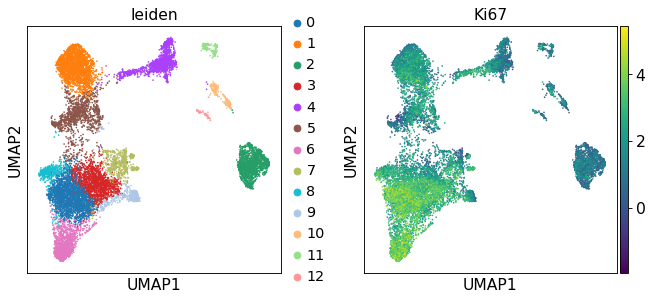

In [27]:
sc.pl.umap(adata_myeloid_2, color=['leiden', 'Ki67'])

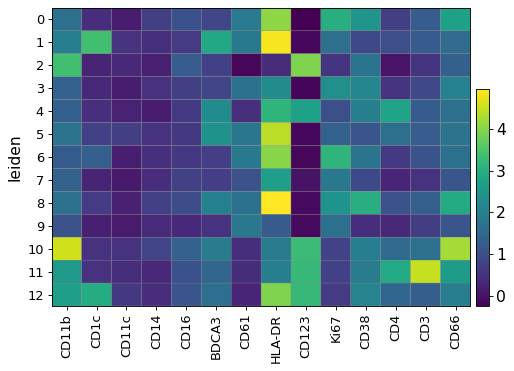

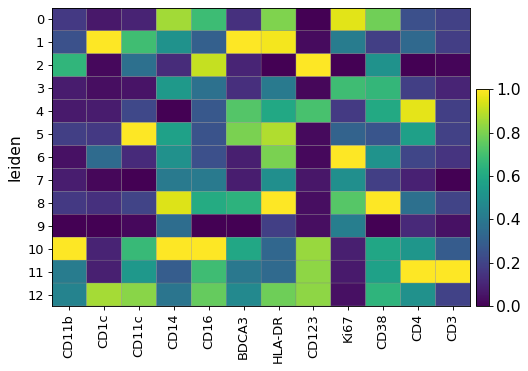

In [28]:
marker_genes = ['CD11b', 'CD1c', 'CD11c', 'CD14', 'CD16', 'BDCA3', 'CD61', 'HLA-DR', 'CD123', 'Ki67', 'CD38', 'CD4', 'CD3', 'CD66']
gs = sc.pl.matrixplot(adata_myeloid_2,marker_genes, groupby='leiden', figsize=(7,5))

marker_genes = ['CD11b', 'CD1c', 'CD11c', 'CD14', 'CD16', 'BDCA3',  'HLA-DR', 'CD123', 'Ki67', 'CD38', 'CD4', 'CD3']
gs = sc.pl.matrixplot(adata_myeloid_2,marker_genes, groupby='leiden', figsize=(7,5), standard_scale='var')



In [78]:
labmap2 = {'0':'Unassigned_APC (Ki67+) 1',
           '1':'cDC_CD1c+ 1',
           '2':'Basophil 1',
           '3':'Unassigned_APC (Ki67+) 2',
           '4':'pDC 1',
           '5':'cDC_CD11c+ 1',
           '6':'Unassigned_APC (Ki67+) 3',
           '7':'Unassigned_APC (Ki67+) 4',
           '8':'Unassigned_APC (Ki67+) 5',
           '9':'Doublet 1',
           '10':'Doublet 2',
           '11':'Doublet 3',
          '12':'cDC_CD1c+ 2'}

In [79]:
adata_myeloid_2.obs['leiden_lab'] = adata_myeloid_2.obs['leiden'].replace(labmap2)

... storing 'leiden_lab' as categorical
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


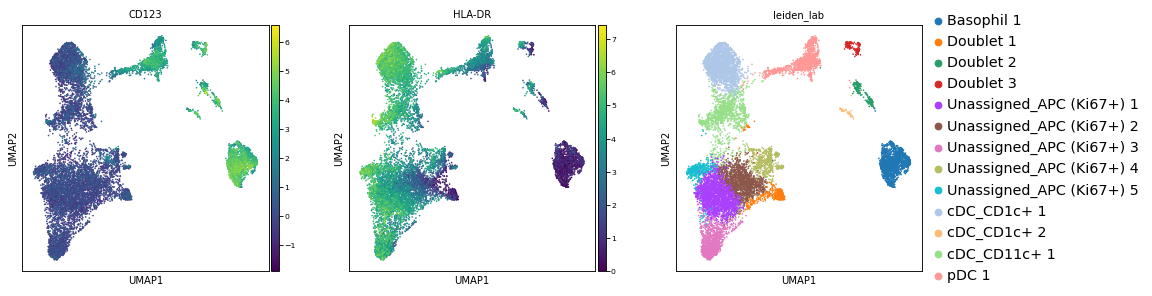

In [80]:
sc.pl.umap(adata_myeloid_2, color=['CD123', 'HLA-DR', 'leiden_lab'])

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


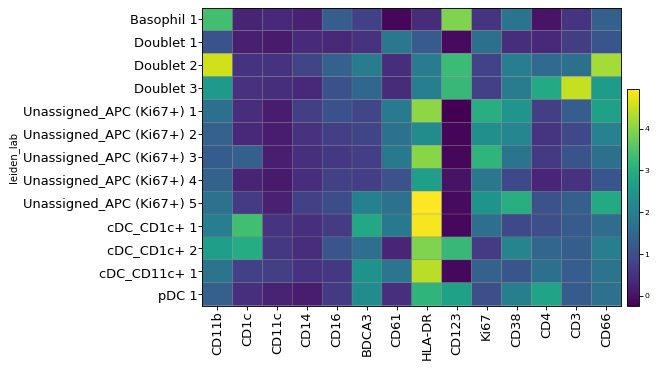

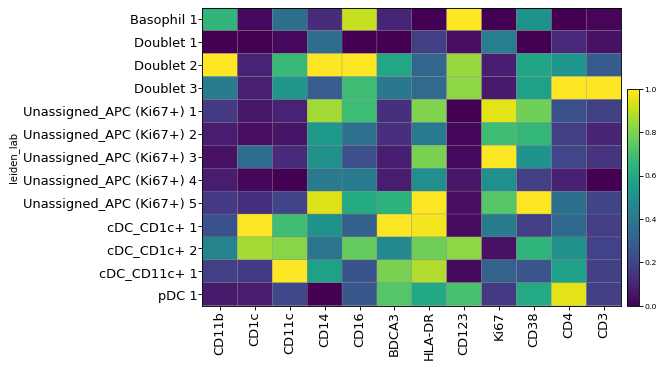

In [81]:
marker_genes = ['CD11b', 'CD1c', 'CD11c', 'CD14', 'CD16', 'BDCA3', 'CD61', 'HLA-DR', 'CD123', 'Ki67', 'CD38', 'CD4', 'CD3', 'CD66']
gs = sc.pl.matrixplot(adata_myeloid_2,marker_genes, groupby='leiden_lab', figsize=(7,5))

marker_genes = ['CD11b', 'CD1c', 'CD11c', 'CD14', 'CD16', 'BDCA3',  'HLA-DR', 'CD123', 'Ki67', 'CD38', 'CD4', 'CD3']
gs = sc.pl.matrixplot(adata_myeloid_2,marker_genes, groupby='leiden_lab', figsize=(7,5), standard_scale='var')


In [82]:
myeloid_file2 = os.path.join(adir, project_name + '.DoubletFilt.COMBAT.SubtractCNMF.UMAP.Leiden.MyeloidIter2DCsBasophils.h5ad')
print(myeloid_file2)

../../../../../data/InVivo/Cytof/Full_IRF_SerialSac_Cytof_Fixid.1M.DoubletFilt.COMBAT.SubtractCNMF.UMAP.Leiden.MyeloidIter2DCsBasophils.h5ad


In [83]:
save_adata(adata_myeloid_2, myeloid_file2, gcs=gcs)

Only considering the two last: ['.MyeloidIter2DCsBasophils', '.h5ad'].
Only considering the two last: ['.MyeloidIter2DCsBasophils', '.h5ad'].


In [84]:
adata_myeloid_1.obs.loc[:, 'leiden_lab'] = adata_myeloid_1.obs.loc[:, 'leiden_lab'].astype(str)
adata_myeloid_1.obs.loc[adata_myeloid_2.obs.index, 'leiden_lab'] = adata_myeloid_2.obs['leiden_lab']

In [85]:
adata_myeloid_1.obs['leiden_lab_group'] = adata_myeloid_1.obs['leiden_lab'].apply(lambda x: x.split(' ')[0])

... storing 'leiden_lab' as categorical
... storing 'leiden_lab_group' as categorical


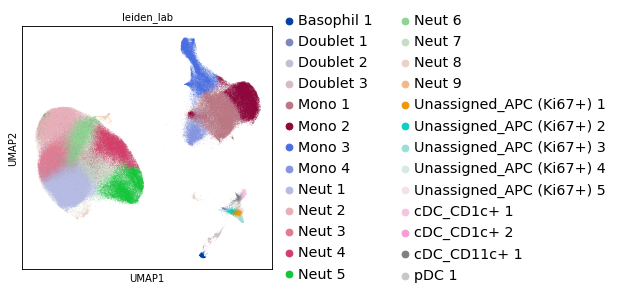

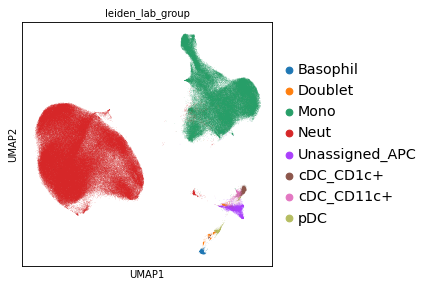

In [86]:
sc.pl.umap(adata_myeloid_1, color='leiden_lab')
sc.pl.umap(adata_myeloid_1, color='leiden_lab_group')

In [87]:

myeloid_file3 = os.path.join(adir, project_name + '.DoubletFilt.COMBAT.SubtractCNMF.UMAP.Leiden.MyeloidIter2.h5ad')
print(myeloid_file3)

../../../../../data/InVivo/Cytof/Full_IRF_SerialSac_Cytof_Fixid.1M.DoubletFilt.COMBAT.SubtractCNMF.UMAP.Leiden.MyeloidIter2.h5ad


In [88]:
save_adata(adata_myeloid_1, myeloid_file3, gcs=gcs)

Only considering the two last: ['.MyeloidIter2', '.h5ad'].
Only considering the two last: ['.MyeloidIter2', '.h5ad'].


In [89]:
annot_file = os.path.join(adir, project_name + '.DoubletFilt.COMBAT.SubtractCNMF.UMAP.Leiden.SubclusterB.h5ad')
print(annot_file)

../../../../../data/InVivo/Cytof/Full_IRF_SerialSac_Cytof_Fixid.1M.DoubletFilt.COMBAT.SubtractCNMF.UMAP.Leiden.SubclusterB.h5ad


In [90]:
adata = read_adata(annot_file, gcs=False)

Only considering the two last: ['.SubclusterB', '.h5ad'].
Only considering the two last: ['.SubclusterB', '.h5ad'].


In [91]:
adata

AnnData object with n_obs × n_vars = 943558 × 42 
    obs: 'BCKG190Di_CKG', 'Ba138Di_Ba138Di', 'Center', 'Cs133Di_Environ', 'DNA1', 'DNA1_Norm', 'DNA2', 'DNA2_Norm', 'DNA_Norm_Sum', 'DNA_Sum_Norm', 'DPI', 'DPIc', 'Event_length', 'I127Di_127I', 'Multiplex_Barcode', 'Multiplex_Group', 'Offset', 'Pb208Di_Environ', 'Pd102Di_BC1', 'Pd104Di_BC2', 'Pd105Di_BC3', 'Pd106Di_BC4', 'Pd108Di_BC5', 'Pd110Di_BC6', 'Period', 'Residual', 'Sn120Di_Environ', 'Time', 'Width', 'Xe131Di_Environ', 'animal', 'batch', 'clinical_score', 'context', 'intensity_sum', 'is_doublet', 'leiden', 'leiden_lab', 'leiden_lab_group', 'n_counts', 'n_genes', 'num', 'samp', 'sample', 'sum_intensity', 'leiden14', 'leiden13', 'leiden10', 'leiden12', 'Subclustering', 'SubclusteringGroup', 'Doublet'
    var: 'gene_symbol', 'metal', 'full_id'
    uns: 'DPIc_colors', 'leiden', 'leiden10_colors', 'leiden12_colors', 'leiden13_colors', 'leiden14_colors', 'leiden_colors', 'leiden_lab_colors', 'leiden_lab_group_colors', 'neighbors', 'pca

In [92]:
adata.obs['SubclusteringGroup'].value_counts()

nan                      784298
B_IgMhi_CD27lo_CD1chi     70246
B_IgMlo_CD27hi_CD1chi     40238
B_IgMhi_CD27lo_CD1clo     30206
B_IgMlo_CD27hi_CD1clo     17183
Plasmablast                1387
Name: SubclusteringGroup, dtype: int64

In [93]:
adata.obs['Subclustering'] = adata.obs['Subclustering'].astype(str)
adata.obs['SubclusteringGroup'] =adata.obs['SubclusteringGroup'].astype(str)

In [94]:
adata.obs.loc[adata_myeloid_1.obs.index, 'Subclustering'] = adata_myeloid_1.obs['leiden_lab']
adata.obs.loc[adata_myeloid_1.obs.index, 'SubclusteringGroup'] = adata_myeloid_1.obs['leiden_lab_group']

In [95]:
pd.crosstab(adata.obs['leiden_lab_group'], adata.obs['SubclusteringGroup'])

SubclusteringGroup,B_IgMhi_CD27lo_CD1chi,B_IgMhi_CD27lo_CD1clo,B_IgMlo_CD27hi_CD1chi,B_IgMlo_CD27hi_CD1clo,Basophil,Doublet,Mono,Neut,Plasmablast,Unassigned_APC,cDC_CD11c+,cDC_CD1c+,nan,pDC
leiden_lab_group,,,,,,,,,,,,,,
B,70237,30202,40238,17183,0,0,0,0,39,0,0,0,0,0
Doublet,0,0,0,0,0,0,0,0,0,0,0,0,43,0
HLA-DR_high,0,0,0,0,1743,982,121,38,0,6087,1251,2266,0,1375
Mono/DC,0,0,0,0,0,19,102100,431,0,29,80,42,0,3
NK,0,0,0,0,0,0,0,0,0,0,0,0,34636,0
Neut,0,0,0,0,0,8,776,214255,0,8,3,0,0,0
Plasmablast,9,4,0,0,0,0,0,0,1348,0,0,0,0,0
RBC,0,0,0,0,0,0,0,0,0,0,0,0,7030,0
Tc,0,0,0,0,0,0,0,0,0,0,0,0,187970,0


In [96]:
annot_file_out = os.path.join(adir, project_name + '.DoubletFilt.COMBAT.SubtractCNMF.UMAP.Leiden.SubclusterBMyeloid.h5ad')
print(annot_file_out)

../../../../../data/InVivo/Cytof/Full_IRF_SerialSac_Cytof_Fixid.1M.DoubletFilt.COMBAT.SubtractCNMF.UMAP.Leiden.SubclusterBMyeloid.h5ad


In [97]:
save_adata(adata, annot_file_out, gcs=gcs)

Only considering the two last: ['.SubclusterBMyeloid', '.h5ad'].
Only considering the two last: ['.SubclusterBMyeloid', '.h5ad'].


... storing 'Subclustering' as categorical
... storing 'SubclusteringGroup' as categorical


## Output figures

In [3]:

myeloid_file3 = os.path.join(adir, project_name + '.DoubletFilt.COMBAT.SubtractCNMF.UMAP.Leiden.MyeloidIter2.h5ad')
print(myeloid_file3)

../../../../../data/InVivo/Cytof/Full_IRF_SerialSac_Cytof_Fixid.1M.DoubletFilt.COMBAT.SubtractCNMF.UMAP.Leiden.MyeloidIter2.h5ad


In [4]:
adata_myeloid_1 = read_adata(myeloid_file3, gcs=gcs)

Only considering the two last: ['.MyeloidIter2', '.h5ad'].
Only considering the two last: ['.MyeloidIter2', '.h5ad'].


In [5]:
expression_full = pd.DataFrame(adata_myeloid_1.X, index=adata_myeloid_1.obs.index, columns=adata_myeloid_1.var.index)

In [6]:
obs = adata_myeloid_1.obs.copy()

In [7]:
obs['leiden_lab_group'].unique()

[Mono, Neut, cDC_CD1c+, Doublet, pDC, Unassigned_APC, cDC_CD11c+, Basophil]
Categories (8, object): [Mono, Neut, cDC_CD1c+, Doublet, pDC, Unassigned_APC, cDC_CD11c+, Basophil]

In [8]:
genes_to_plot = ['CD66', 'CD11b', 'CD123', 'HLA-DR', 'BDCA3', 'CD14', 'CD16', 'CD4', 'CD1c', 'CD11c', 'CD38', 'Ki67']
celltype_order = ['Neut', 'Basophil', 'Mono', 'Unassigned_APC', 'pDC', 'cDC_CD1c+', 'cDC_CD11c+']
celltype_order_clean = [x.replace('_', ' ') for x in celltype_order]
obs['Grouped_Clustering'] = pd.Categorical(obs['leiden_lab_group'].apply(lambda x: x.replace('_', ' ')).values, categories=celltype_order_clean)
expression = expression_full.loc[:, genes_to_plot]
obs['UMAP_1'] = adata_myeloid_1.obsm['X_umap'][:,0]
obs['UMAP_2'] = adata_myeloid_1.obsm['X_umap'][:,1]

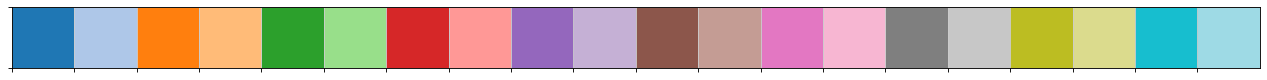

In [9]:
tableau = palettable.tableau.Tableau_20.hex_colors
sns.palplot(tableau)

['Neut',
 'Basophil',
 'Mono',
 'Unassigned APC',
 'pDC',
 'cDC CD1c+',
 'cDC CD11c+']

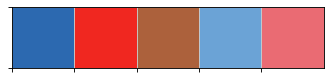

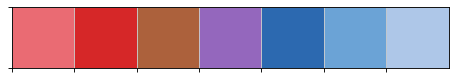

In [10]:
sns.palplot(palettable.tableau.BlueRed_6.hex_colors[:5])
ctcolors = palettable.tableau.BlueRed_6.hex_colors[:5]
ctmap = {'Neut':ctcolors[4], 'Mono':ctcolors[2],'Basophil':tableau[6], 'pDC':ctcolors[0], 'cDC CD1c+':ctcolors[3],
        'cDC CD11c+':tableau[1], 'Unassigned APC':tableau[8]}

sns.palplot([ctmap[x] for x in celltype_order_clean])
obs['ctcolor'] = obs['Grouped_Clustering'].replace(ctmap)
celltype_order_clean

In [11]:
from matplotlib import gridspec
from matplotlib import rcParams

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Myriad Pro']

rcParams['axes.titlesize'] = 9
rcParams['axes.labelsize'] = 9
rcParams['xtick.labelsize'] = 7
rcParams['ytick.labelsize'] = 7

rcParams['xtick.major.pad']='1'
rcParams['ytick.major.pad']='1'

rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

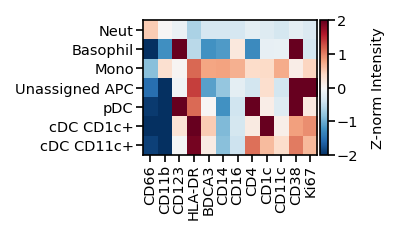

In [33]:
expression_norm = expression.copy()
expression_norm = expression_norm.subtract(expression_norm.mean(axis=0), axis=1)
expression_norm = expression_norm.divide(expression_norm.std(axis=0), axis=1)
average_expression = expression_norm.groupby(obs['Grouped_Clustering']).mean()

width=2.5
heatmap_width=1.7
legend_width=.64
left_space=.35

heatmap_height = .9
bottom_space = .47
top_space = .13
height=heatmap_height+bottom_space+top_space

topval = 1-(top_space/height)
bottomval = bottom_space/height

fig = plt.figure(figsize=(width, height), dpi=150)
full_gs = gridspec.GridSpec(
        nrows=1,
        ncols=2,
        wspace=0,
        hspace=0,
        width_ratios=[
            heatmap_width,
            legend_width,
        ], left=left_space, right=.99, bottom=bottomval, top=topval)


legend_grid = full_gs[0, 1].subgridspec(1, 130, wspace=0, hspace=0,
                                           width_ratios=[.01]*130)

cbar_ax = fig.add_subplot(legend_grid[5:20], ylim=[0,1], xlim=[0,1], frameon=False)
size_legend_ax = fig.add_subplot(legend_grid[50:], ylim=[0,1], xlim=[0,1], frameon=False, yticks=[], xticks=[])

heatmap_ax = fig.add_subplot(full_gs[0])

allcolors = average_expression.copy()
vmin=-2.
vmax=2.
cmap = "RdBu_r"

cim= heatmap_ax.imshow(allcolors.loc[celltype_order_clean, genes_to_plot], aspect='auto', cmap=cmap, vmin=vmin, vmax=vmax)
heatmap_ax.grid(False)
heatmap_ax.set_yticks(np.arange(len(celltype_order_clean)))
heatmap_ax.set_yticklabels(celltype_order_clean)

heatmap_ax.set_xticks(np.arange(len(genes_to_plot)))
heatmap_ax.set_xticklabels(genes_to_plot, rotation=90)
#heatmap_ax.set_title('Myeloid - CyTOF', pad=0)

'''
for (x, g) in enumerate(genes_to_plot):
    for (y, ct) in enumerate(celltype_order):
        dotsize = alldotsize.loc[ct,g]
        heatmap_ax.scatter(x, y, color="none", marker='o',
                                      s=dotsize, norm=None,
                                       edgecolor='k', linewidth=.5)
'''
        
        
        

plt.colorbar(cim, cax=cbar_ax,)
#matplotlib.colorbar.ColorbarBase(cbar_ax, cmap=cmap, norm=normalize, ticks=[0,1,2,3,4,5,6,7])


vals = np.linspace(.2, 1, num=5)
leg_dot_size =  (vals * 10) ** 2
leg_dot_color = 'k'
text_offset = .2
leg_x_pos = .3

leg_x = np.array([leg_x_pos]*5)
leg_y = np.linspace(.45, .82, 5)

sizelegendfontsize = 7
size_legend_ax.text(.7, .5, 'Z-norm Intensity', fontsize=sizelegendfontsize, ha='left', va='center', rotation=90)

figure_file = os.path.join(results_dir, "Subcluster.Myeloid.Cytof.Invivo.Dotplot.pdf")
fig.savefig(figure_file, dpi=200)


In [26]:
box_height=1.5
box_width=1.5
title_height=.15
left_space = .02
right_space = .98
bottom_space = .02
top_space = .98

dotsize=.5
valdpi = 200

In [27]:
obs['ctcolor'].unique()

array(['#AC613C', '#EA6B73', '#6BA3D6', nan, '#2C69B0', '#9467BD',
       '#AEC7E8', '#D62728'], dtype=object)

In [28]:
obs['Grouped_Clustering'].isnull().sum()

1009

In [29]:
obs_nodoublet = obs.loc[~obs['Grouped_Clustering'].isnull(), :]

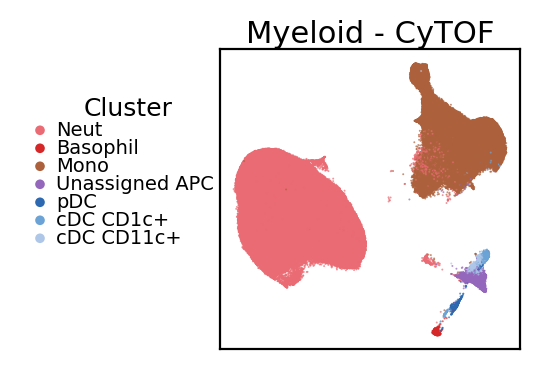

In [32]:
leg_width=1.
ax_width = leg_width+box_width
fig_width = ax_width/(right_space-left_space)
ax_height = title_height+box_height
fig_height = ax_height/(top_space-bottom_space)
fig_width, fig_height

fig = plt.figure(figsize=(fig_width, fig_height), dpi=valdpi)
gs = gridspec.GridSpec(2, 2, fig,
                       left_space, bottom_space, right_space,top_space,
                       hspace=0.0, wspace=0.0,
                       width_ratios=(leg_width, box_width),
                       height_ratios=(title_height, box_height))

ax = fig.add_subplot(gs[1, 1],
          xscale='linear', yscale='linear',
          frameon=True, ylabel='', xlabel='',
          title='',
          xticks=[], yticks=[])


ax.scatter(obs_nodoublet['UMAP_1'], obs_nodoublet['UMAP_2'], c=obs_nodoublet['ctcolor'],
           s=dotsize, alpha=.7, edgecolor='None', rasterized=True)

legend_ax = fig.add_subplot(gs[1, 0],
          xscale='linear', yscale='linear',
          frameon=False, ylabel='', xlabel='',
          title='',
          xticks=[], yticks=[])

legend_ax.set_ylim([0, 1])
legend_ax.set_xlim([0, 1])
marker_x=.05

marker_x=.1
N = len(celltype_order)
for (i,y) in enumerate(np.linspace(.73, .37, num=N)):
  ct = celltype_order_clean[i]
  legend_ax.scatter(marker_x, y, color=ctmap[ct], s=12, edgecolor='None')
  legend_ax.text(marker_x+.08, y-.015, ct, fontsize=7)
legend_ax.text(.32, .78, 'Cluster', fontsize=9)

title_ax = fig.add_subplot(gs[0, 1],
          xscale='linear', yscale='linear',
          frameon=False, ylabel='', xlabel='',
          title='', xlim=[0,1], ylim=[0,1],
          xticks=[], yticks=[])

title_ax.text(0.50, 1.0, 'Myeloid - CyTOF', va='top', ha='center',
              fontsize=11, fontdict=dict(weight='normal'),
              clip_on=False)

figure_file = os.path.join(results_dir, "Subcluster.UMAP.Myeloid.Cytof.Invivo.Celltype.pdf")
fig.savefig(figure_file, dpi=300)